# COT

[What is COT report?](https://www.investopedia.com/terms/c/cot.asp)

COT报告也称为期货持仓报告，由美国CFTC公布，包含美国期货市场上大型交易商的持仓明细，例如持有多少多头合约，空头合约和未平仓合约等。

COT报告每周公布一次，公布时间是美东时间周五下午，数据采集时间截止到公布当周周二。

报告类型：

1. Legacy - 传统报告
2. Supplemental - 补充报告
3. Disaggregated - 分类报告
4. Traders in financial futures - 金融期货交易者报告

传统报告将市场参与者分为两类：非商业交易者和商业交易者。

* 非商业(noncommercial): 一般指商品生产商或制造商，期货主要用于对冲。
* 商业(commercial): 一般指投机性头寸，例如对冲基金或投行持仓的合约。

补充报告包含13种精选农产品合约，把市场参与者分为三类：非商业，商业和指数交易者。

分类报告是传统报告的深入，将市场参与者进一步细分：

* Producer/Merchant/Processor/User: 生产商/商家/加工/用户，一般用期货来对冲商品风险
* Swap Dealers: 掉期交易商，期货头寸主要用于对冲掉期交易的风险，对手方既可能是生产商，也可能是对冲基金
* Managed Money: 管理基金，指专门进行期货交易的实体，例如CTA, CPO, 或者对冲基金等
* Other Reportables: 其它报告，指小型交易者

金融期货交易者报告包括金融合约，例如货币，美国国债，欧洲美元，股票和彭博商品指数等。该报告将市场参与者分为四类：

* Dealer/Intermediary: 做市商/中介，这些参与者被视为市场“卖方”，它们设计并出售期货合约，例如投行，掉期交易商或其它衍生品公司
* Asset Manager/Institutional: 资产管理人/机构，机构投资者，例如养老基金，捐赠基金，保险公司和共同基金等
* Leveraged Funds: 杠杆基金，主要指对冲基金，CTA, CPO等机构
* Other Reportables: 不属于上述三个类别的其它参与者，一般使用期货对冲风险

In [1]:
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import nasdaqdatalink as quandl
import pandas_datareader as pdr

pio.templates.default = "ggplot2"

API_KEY = "JZQBJyMTVrVcLBcxapfi"

## 获取数据

数据源：[Quandl](https://data.nasdaq.com/data/CFTC-commodity-futures-trading-commission-reports)

In [2]:
futures = pd.read_csv("/home/scofieldchen0011/cryptomodels/data/major_futures.csv")

In [3]:
futures

,category,contract,ticker,exchange,quandl_cot_id,yahoo_id
0,index,E-mini S&P500,ES,CME,CFTC/13874A_F_L_ALL,ES=F
1,metals,Gold,GC,COMEX,CFTC/088691_F_L_ALL,GC=F
2,energy,Crude Oil,CL,NYMEX,CFTC/06765A_F_L_ALL,CL=F
3,currency,US Dollar index,DX,ICE,CFTC/098662_F_L_ALL,DX=F
4,crypto,Bitcoin,BTC,CME,CFTC/133741_F_L_ALL,BTC-USD


In [28]:
start_date = "2000-01-01"
end_date = "2022-10-30"

cot_list = []
price_list = []

for _, row in futures.iterrows():
    ticker = row["ticker"]
    
    cot_data = pdr.get_data_quandl(row["quandl_cot_id"], api_key=API_KEY, start=start_date, end=end_date)
    cot_data["ticker"] = ticker
    cot_data.sort_values("Date", ascending=True, inplace=True)
    cot_list.append(cot_data)
    print(f"{ticker}: download cot data")
    
    price_data = pdr.get_data_yahoo(row["yahoo_id"], start=start_date, end=end_date)
    price_data["ticker"] = ticker
    price_list.append(price_data)
    print(f"{ticker}: download price data")

cot_merged = pd.concat(cot_list)
price_merged = pd.concat(price_list)

ES: download cot data
ES: download price data
GC: download cot data
GC: download price data
CL: download cot data
CL: download price data
DX: download cot data
DX: download price data
BTC: download cot data
BTC: download price data


## 计算情绪指标

* 非商业期货净头寸 = 非商业期货多头 - 非商业期货空头
* 将非商业期货净头寸标准化

In [16]:
def scale(s: pd.Series, window: int = 10, method: str = "zscore") -> pd.Series:
    """scale data via different methods
    
    Args:
        s (pd.Series): time-series data to scale
        window (int): rolling window to scale data
        method (str): 'standardization' or 'zscore'
            standardization - scale data to 0-100
            zscore - measure deviation from sample mean
    """
    if method == "zscore":
        rolling_mean = s.rolling(window).mean()
        rolling_std = s.rolling(window).std()
        return (s - rolling_mean) / rolling_std
    elif method == "standardization":
        rolling_min = s.rolling(window).min()
        rolling_max = s.rolling(window).max()
        return (s - rolling_min) / (rolling_max - rolling_min)
    else:
        raise ValueError("Invalid method")

In [47]:
# 选择资产
ticker = "DX"

# 滚动窗口，单位：周
window = 52

# 缩放方法
method = "zscore"

# 选择样本
start_date = "2010-01-01"
end_date = "2022-10-30"

In [48]:
metrics = (
    cot_df
        .query("ticker == @ticker")
        .loc[:, ["Noncommercial Long", "Noncommercial Short"]]
        .rename(columns={
            "Noncommercial Long": "long",
            "Noncommercial Short": "short"
        })
        .assign(net=lambda x: x["long"] - x["short"],
                scaled_net=lambda x: scale(x["net"], window, method))
        .loc[start_date:end_date]
)

metrics.tail()

,long,short,net,scaled_net
Date,,,,
2022-09-13,48984.0,13315.0,35669.0,0.045332
2022-09-20,45704.0,17773.0,27931.0,-2.038291
2022-09-27,47424.0,16862.0,30562.0,-1.414197
2022-10-04,44449.0,12752.0,31697.0,-1.093457
2022-10-11,45079.0,12293.0,32786.0,-0.773294


非商业期货头寸。

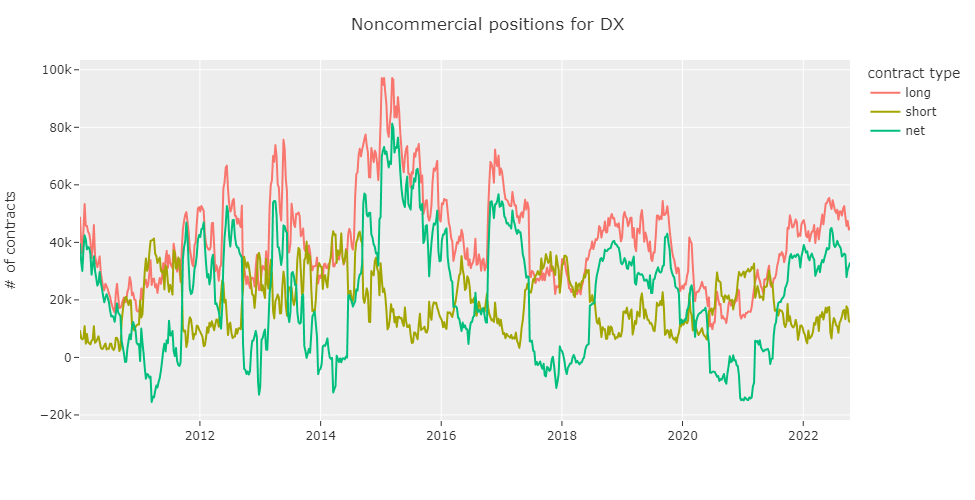

In [49]:
fig = px.line(metrics, x=metrics.index, y=["long", "short", "net"])
fig.update_layout(
    title=f"Noncommercial positions for {ticker}",
    xaxis_title="",
    yaxis_title="# of contracts",
    legend_title="contract type",
    width=800,
    height=500
)
fig.show()

非商业期货净头寸的标准化，作为市场情绪的代理指标。

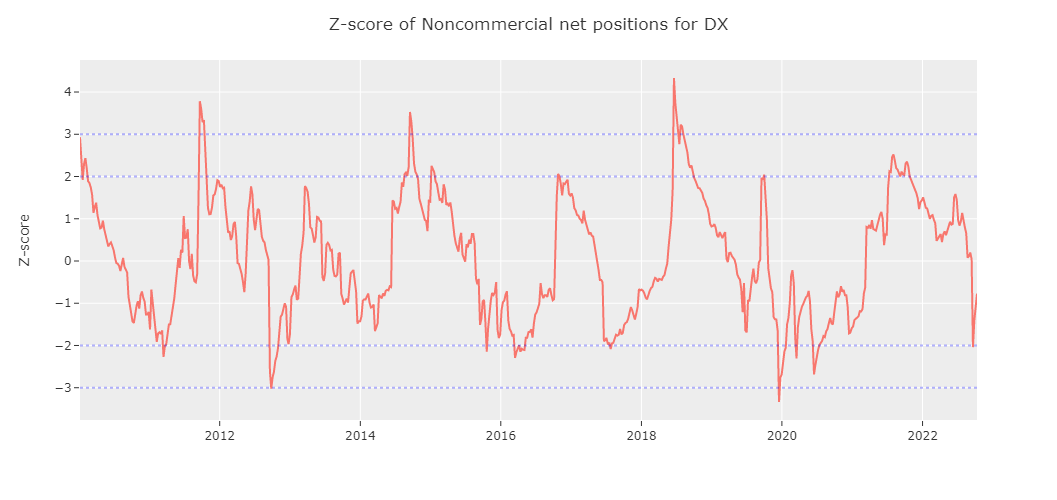

In [50]:
fig = px.line(metrics, x=metrics.index, y="scaled_net")
fig.add_hline(y=2, line_width=2, line_dash="dot", line_color="blue")
fig.add_hline(y=-2, line_width=2, line_dash="dot", line_color="blue")
fig.add_hline(y=3, line_width=2, line_dash="dot", line_color="blue")
fig.add_hline(y=-3, line_width=2, line_dash="dot", line_color="blue")
fig.update_layout(
    title=f"Z-score of Noncommercial net positions for {ticker}",
    xaxis_title="",
    yaxis_title="Z-score",
    width=800,
    height=500
)
fig.show()

TODO

* 研究价格和情绪指标的关系，核心问题：情绪指标是否有领先作用？